In [1]:
notebook_id = 201

<a id="ID_top"></a>
## Map generator | BRI map

Raw data source [here](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/)
Code inspiration [here](https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0)
Nice diagram for panda merge [here](https://medium.com/swlh/merging-dataframes-with-pandas-pd-merge-7764c7e2d46d), example code [here](http://www.datasciencemadesimple.com/join-merge-data-frames-pandas-python/)

Useful guide on categorical mapping with geopands [here](https://dmnfarrell.github.io/plotting/categorical-geopandas-maps)


Using geopandas and natural earth shape file to plot a world map with countries highlighted based on 3 digit iso code.

In [ ]:
#![Image of Joins](https://miro.medium.com/max/1400/1*9eH1_7VbTZPZd9jBiGIyNA.png)

#### Notebook sections:
    
|| [0| Default imports](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

#### Import all packages that could be required

In [2]:
# %load s_package_import.py
# package library, use to ensure consistency across notebooks, refresh periodically
# general packages
import os # use with os.listdir(_path_)
import requests
import csv
import time
from datetime import datetime
from shutil import copyfile

#temp check
#from shutil import make_archive
#import zipfile

# data analysis packages
import pandas as pd
pd.options.display.max_columns = None # don't truncate columns
#pd.options.display.max_rows = None

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes

# custom scripts
import s_file_export
import s_filepaths
import s_un_comtrade_extract as s_un
import s_adj_matrix_plot

#=== network analysis
import networkx as nx
#=== gavity modelling
import gme as gme


#### Import module and declare path variables
`import s_filepaths.py`

In [4]:
# import ref file
import s_filepaths

# declare local variables to work with
path_raw = s_filepaths.path_raw
path_raw_dl = s_filepaths.path_raw_dl
path_store = s_filepaths.path_store
path_live = s_filepaths.path_live
path_map = s_filepaths.path_map
path_image = s_filepaths.path_images

<a id="ID_part1"></a>
### Part 1 | Import map data
|| [0| Default imports](#ID_top) || [1|Part1 Import data](#ID_part1) || [2|Part2 Load BRI data](#ID_part2) || [3|Part3 Merge, prep, visualise](#ID_part3) || 

In [5]:
os.listdir(f"{path_map}ne_50m_admin_0_countries")

['ne_50m_admin_0_countries.VERSION.txt',
 'ne_50m_admin_0_countries.prj',
 'ne_50m_admin_0_countries.README.html',
 'ne_50m_admin_0_countries.dbf',
 'ne_50m_admin_0_countries.shp',
 'ne_50m_admin_0_countries.cpg',
 'ne_50m_admin_0_countries.shx']

In [6]:
# file path
base_shape_file = f"{path_map}ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"

# geopandas dataframe
gdf_map = gpd.read_file(base_shape_file)[["ADM0_A3","ADMIN","geometry"]]
gdf_map.columns = ["iso_3","country_name","geometry"]

In [7]:
gdf_map.head()

,iso_3,country_name,geometry
0,ZWE,Zimbabwe,POLYGON ((31.28789062500002 -22.40205078125001...
1,ZMB,Zambia,"POLYGON ((30.39609375000001 -15.64306640625, 3..."
2,YEM,Yemen,"(POLYGON ((53.08564453125001 16.648388671875, ..."
3,VNM,Vietnam,"(POLYGON ((104.06396484375 10.3908203125, 104...."
4,VEN,Venezuela,(POLYGON ((-60.82119140624999 9.13837890624999...


<a id="ID_part2"></a>
### Part 2 | BRI country list
|| [0| Default imports](#ID_top) || [1|Part1 Import data](#ID_part1) || [2|Part2 Load BRI data](#ID_part2) || [3|Part3 Merge, prep, visualise](#ID_part3) || 

In [8]:
# BRI country list
print(os.listdir(f"{path_live}")) #store_bri_countries_Dumor_Yao_20200621_1901.csv.gzip

['input_101_master_country_table.csv.csv.gzip', 'input_test.csv.gzip', 'input_un_com_2013.csv.gzip', 'input_un_com_2012.csv.gzip', 'input_un_com_2006-2009.csv.gzip', '.DS_Store', 'input_101_master_country_table.csv.gzip', 'input_un_codes_ref.csv.gzip', 'input_bri_countries_manual_2020.csv.gzip', 'input_un_com_2016-2019.csv.gzip', 'input_un_com_2002-2005.csv.gzip', 'input_un_com_2014.csv.gzip', 'input_un_com_2015.csv.gzip', 'input_bri_countries_Dumor_Yao.csv.gzip', '2_raw_explainer_doc.md', 'input_dynamic_gravity.csv.gzip', 'input_un_com_2010_merged_ref.csv.gzip', 'input_gme_data_joined.csv.gzip', 'input_un_sample.csv.gzip']


In [9]:
# BRI country list
#print(os.listdir(f"{path_store}")[3]) #store_bri_countries_Dumor_Yao_20200621_1901.csv.gzip
df_bri_countries = pd.read_csv(f"{path_live}input_101_master_country_table.csv.gzip",compression = "gzip")
print(f"Number of BRI countries: {len(df_bri_countries)}")

df_bri_countries = df_bri_countries[df_bri_countries.bri_data == 1.0].copy()
df_bri_countries.drop("country_name",axis =1, inplace= True)
df_bri_countries.head()

Number of BRI countries: 253


,iso_3,lat,long,bri_year,bri_data,un_code,un_flag
1,AFG,34.649338,67.113739,2016.0,1.0,4.0,1.0
2,AGO,-11.704597,16.376490,2018.0,1.0,24.0,1.0
5,ALB,41.094173,20.045958,2017.0,1.0,8.0,1.0
8,ARE,25.094378,55.454674,2017.0,1.0,784.0,1.0
10,ARM,40.379307,44.671028,2015.0,1.0,51.0,1.0


In [10]:
df_bri_countries["bri_year"].value_counts()

2018.0    64
2017.0    23
2015.0    18
2019.0    13
2013.0     7
2016.0     5
2014.0     1
2020.0     1
Name: bri_year, dtype: int64

In [17]:
df_bri_countries.shape

(138, 8)

In [11]:
label_series = []

for entry in df_bri_countries["bri_year"]:
    
    try:
        int(entry)
        temp_label = f"({int(entry)}) participating country"
        label_series.append(temp_label)
        
    except:
        temp_label = f"(Year unclear) participating country"
        label_series.append(temp_label)
        
        
df_bri_countries["BRI_label"] = label_series
df_bri_countries.head()

,iso_3,lat,long,bri_year,bri_data,un_code,un_flag,BRI_label
1,AFG,34.649338,67.113739,2016.0,1.0,4.0,1.0,(2016) participating country
2,AGO,-11.704597,16.376490,2018.0,1.0,24.0,1.0,(2018) participating country
5,ALB,41.094173,20.045958,2017.0,1.0,8.0,1.0,(2017) participating country
8,ARE,25.094378,55.454674,2017.0,1.0,784.0,1.0,(2017) participating country
10,ARM,40.379307,44.671028,2015.0,1.0,51.0,1.0,(2015) participating country


<a id="ID_part3"></a>
### Part 3 | Merge and prep data
|| [0| Default imports](#ID_top) || [1|Part1 Import data](#ID_part1) || [2|Part2 Load BRI data](#ID_part2) || [3|Part3 Merge, prep, visualise](#ID_part3) || 

In [12]:
gdf_map_merged = gdf_map.merge(df_bri_countries, on = "iso_3",how = "left",copy = False)
#gdf_map_merged["BRI_membership"].fillna(0,inplace= True)
print(gdf_map_merged.bri_data.value_counts())
#gdf_map_merged.BRI_membership.replace(0,2,inplace= True)

1.0    137
Name: bri_data, dtype: int64


In [13]:
# Colour column
colour_series = []

for entry in list(gdf_map_merged.bri_data):
    
    if entry == 1:
        colour_series.append("#aa381e")
    else:
        colour_series.append("white")

gdf_map_merged["colour"] = colour_series
gdf_map_merged.head()

,iso_3,country_name,geometry,lat,long,bri_year,bri_data,un_code,un_flag,BRI_label,colour
0,ZWE,Zimbabwe,POLYGON ((31.28789062500002 -22.40205078125001...,-18.929132,29.789742,2018.0,1.0,716.0,1.0,(2018) participating country,#aa381e
1,ZMB,Zambia,"POLYGON ((30.39609375000001 -15.64306640625, 3...",-13.461213,27.676571,2018.0,1.0,894.0,1.0,(2018) participating country,#aa381e
2,YEM,Yemen,"(POLYGON ((53.08564453125001 16.648388671875, ...",14.599034,45.970097,2017.0,1.0,887.0,1.0,(2017) participating country,#aa381e
3,VNM,Vietnam,"(POLYGON ((104.06396484375 10.3908203125, 104....",15.463247,106.562180,2017.0,1.0,704.0,1.0,(2017) participating country,#aa381e
4,VEN,Venezuela,(POLYGON ((-60.82119140624999 9.13837890624999...,9.367815,-67.193985,2018.0,1.0,862.0,1.0,(2018) participating country,#aa381e


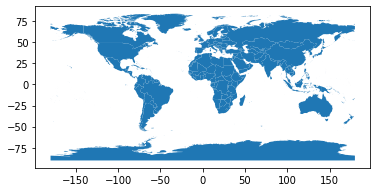

In [14]:
# sample plot
gdf_map_merged.plot()

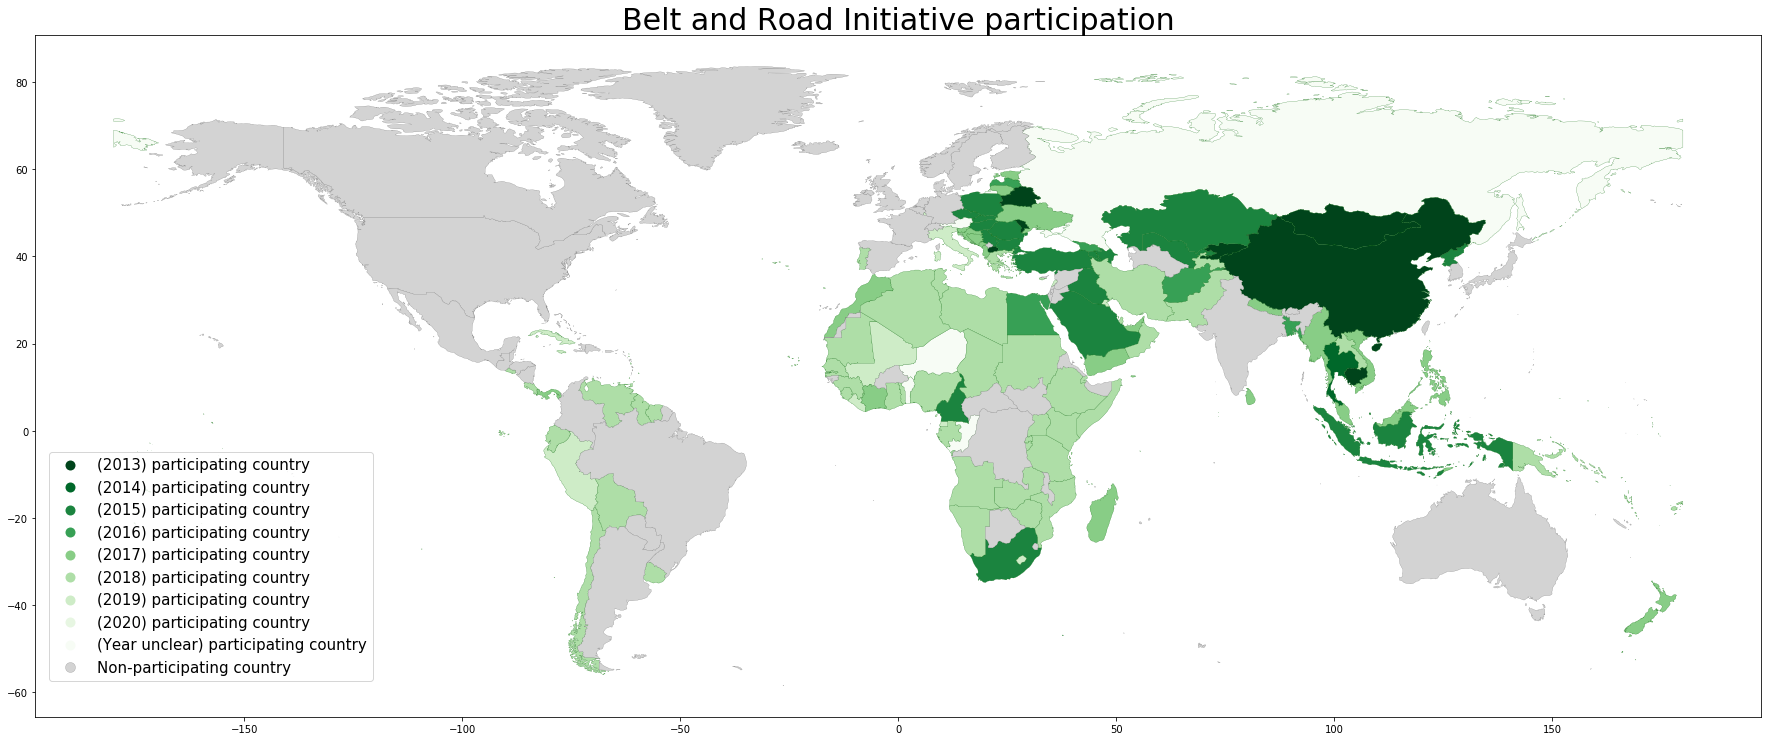

In [15]:
# dataframe to feed plot
gdf_plot = gdf_map_merged[(gdf_map_merged.country_name!="Antarctica")]
number_categories = len(gdf_plot.BRI_label.unique())

# Plotting # define number of bins we want from cmap
fig, ax_bri = plt.subplots(1, figsize=(25,20))

gdf_plot.plot(
    # Data
    column = "BRI_label",categorical = True,
    
    # Colouring map and data
    cmap= plt.cm.get_cmap("Greens_r",number_categories),
    #color = gdf_plot.colour,
    linewidth = 0.2,
    edgecolor = "darkgreen",
    hatch = "",
    
    # Missing data
    missing_kwds={
            "color": "lightgrey",
            #"edgecolor": "lightcoral",
            "edgecolor": "dimgrey",
            "linewidth": 0.2,
            #"hatch": "////",
            "label": "Non-participating country",
    },
    # Legend
    legend= True,legend_kwds={'bbox_to_anchor':(0.2,0.4),'fontsize':15,'frameon':True},
    
    # Assign to axis
    ax =ax_bri)

# Labels
#gdf_plot.apply(lambda x: ax_bri.annotate(s=x.iso_3, xy=x.geometry.centroid.coords[0], ha='center',color = "black",fontsize = 6),axis=1)

# Final customisation (map axis, title and layout padding)
ax_bri.axis('on')
ax_bri.set_title("Belt and Road Initiative participation",fontsize=30)
plt.tight_layout()

In [16]:
# Save image
keyword = "_no_labels"
fig.savefig(f"{path_image}{notebook_id}_BRI_members{keyword}.png",dpi=300)

### Improvements

Countries over time, we are recreating something like this [here](https://green-bri.org/countries-of-the-belt-and-road-initiative-bri) || Chinese source: https://www.yidaiyilu.gov.cn/gbjg/gbgk/77073.htm **DONE**

2015 65 members reference here [here](https://www.fbicgroup.com/sites/default/files/B&R_Initiative_65_Countries_and_Beyond.pdf) **DONE**

Use shading of colours to demonstrate the different years. **DONE**